# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Hydro Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\hydro_production_dataset.csv')

data.head()

,Country,Date,Value,Precipitation
0,Australia,2023-03-01,1215.8041,0.080641
1,Australia,2023-02-01,942.5558,0.127869
2,Australia,2023-01-01,1190.7296,0.159242
3,Australia,2022-12-01,1110.1523,0.105662
4,Australia,2022-11-01,1397.5839,0.073524


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

hydro_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'Hydro' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Precipitation']
    ]
    
    # Store the filtered data in the dictionary
    hydro_production_data[country] = country_energy_production.reset_index(drop=True)

hydro_production_data['Germany']

,Date,Value,Precipitation
0,2023-03-01,2121.2467,0.135779
1,2023-02-01,1571.3986,0.071635
2,2023-01-01,2081.3454,0.109122
3,2022-12-01,1950.7081,0.103914
4,2022-11-01,1848.0426,0.084913
...,...,...,...
154,2010-05-01,2298.6990,0.151205
155,2010-04-01,1946.7940,0.044852
156,2010-03-01,2202.3910,0.084032
157,2010-02-01,1780.0470,0.090249


# Resample to daily data

In [4]:
# hypro_production_data
for country_data in hydro_production_data:
    
    # set time as the index
    hydro_production_data[country_data]['Date'] = pd.to_datetime(hydro_production_data[country_data]['Date'])
    hydro_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    hydro_production_data[country_data]['Value'] = (hydro_production_data[country_data]['Value']/
                                                    hydro_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = hydro_production_data[country_data].resample('D').interpolate('linear')
    hydro_production_data[country_data] = daily_data
    
hydro_production_data['Germany']

,Value,Precipitation
Date,,
2010-01-01,67.049355,0.074334
2010-01-02,66.937218,0.074848
2010-01-03,66.825081,0.075361
2010-01-04,66.712944,0.075874
2010-01-05,66.600807,0.076388
...,...,...
2023-02-25,66.669322,0.126616
2023-02-26,67.108820,0.128906
2023-02-27,67.548318,0.131197


## Split Train and Test Data

In [5]:
data = hydro_production_data['Germany']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date][['Value']], data[split_date:][['Value']]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                Value
Date                 
2010-01-01  67.049355
2010-01-02  66.937218
2010-01-03  66.825081
2010-01-04  66.712944
2010-01-05  66.600807
(4019, 1)

                Value
Date                 
2021-01-01  59.511294
2021-01-02  59.955676
2021-01-03  60.400059
2021-01-04  60.844441
2021-01-05  61.288824
(790, 1)


## Univaraite - ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,1,0)
#### Figure below show the result from R:
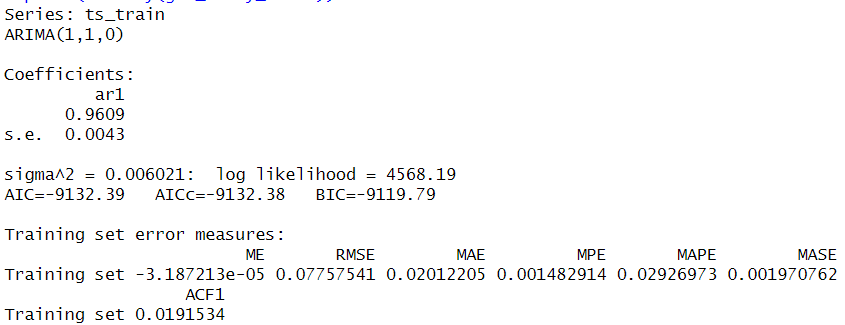

In [64]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
ger_hydro_arima_model = r_load("F:\APU\FYP\SEM 2\Report Doc\R script\ger_hydro_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [66]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(ger_hydro_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test.values))
mse = mean_squared_error(predictions.rx('mean')[0], test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  7.416761665723115
Mean Squared Error:  85.50444847655713
Root Mean Squared Error:  9.246861547387693


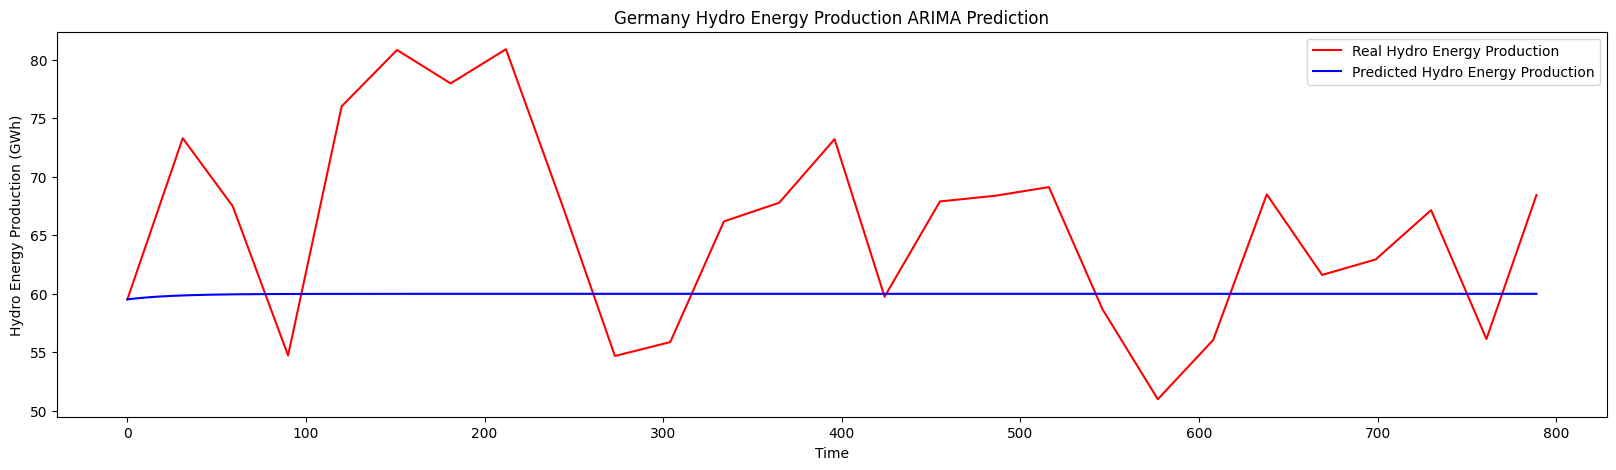

In [67]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('Germany Hydro Energy Production ARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy Production (GWh)')
plt.legend()
plt.show()

## Univariate - SVR - Daily

In [6]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [70]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data to fit
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(3654, 365) (3654,)


In [71]:
# Build and Train the SVM Model
ger_daily_svr = SVR(kernel='linear',gamma=0.5, C=10, epsilon = 0.01)
ger_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')

In [72]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Hydro Energy Production
svr_y_pred = ger_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [73]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  6.3280421446358615
Mean Squared Error:  0.0489840539056445
Root Mean Squared Error:  0.22132341472524886


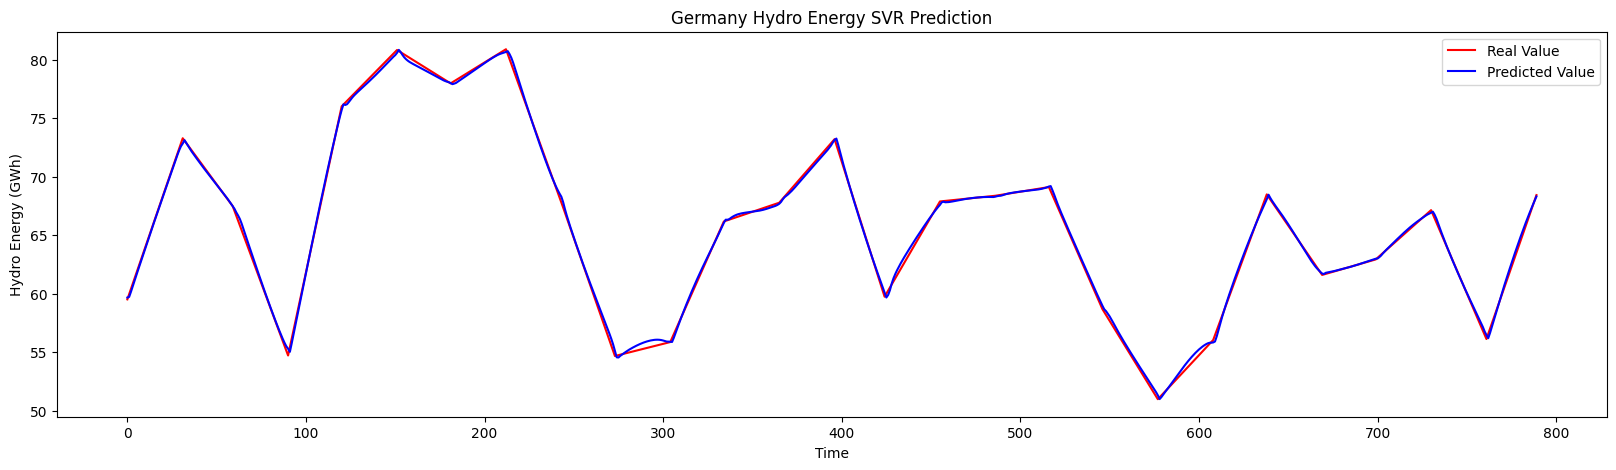

In [74]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('Germany Hydro Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate ANN - Daily

In [50]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)

In [13]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test.values, time_steps)

X_train.shape

(3654, 365, 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

# Create the model
ger_daily_ann = Sequential()
ger_daily_ann.add(Dense(84, activation='tanh', input_shape=(365,)))
ger_daily_ann.add(Dropout(0.2))
ger_daily_ann.add(Dense(1, activation='linear'))

ger_daily_ann.compile(optimizer='adam', loss='mean_squared_error')

ger_daily_ann.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
229/229 [==============================] - 3s 3ms/step - loss: 0.1163
Epoch 2/100
229/229 [==============================] - 1s 3ms/step - loss: 0.0317
Epoch 3/100
229/229 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 4/100
229/229 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 5/100
229/229 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 6/100
229/229 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 7/100
229/229 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 8/100
229/229 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 9/100
229/229 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 10/100
229/229 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 11/100
229/229 [==============================] - 1s 3ms/step - loss: 0.0058
Epoch 12/100
229/229 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 13/100


In [51]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

ann_y_pred = ger_daily_ann.predict(X_test)
ann_y_pred = sc.inverse_transform(ann_y_pred)

print("Mean Absolute Error: ", mean_absolute_error(ann_y_pred, test.values))
mse = mean_squared_error(ann_y_pred, test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

25/25 [==============================] - 2s 7ms/step
Mean Absolute Error:  0.6699469964278704
Mean Squared Error:  0.6231260963614996
Root Mean Squared Error:  0.7893833646343832


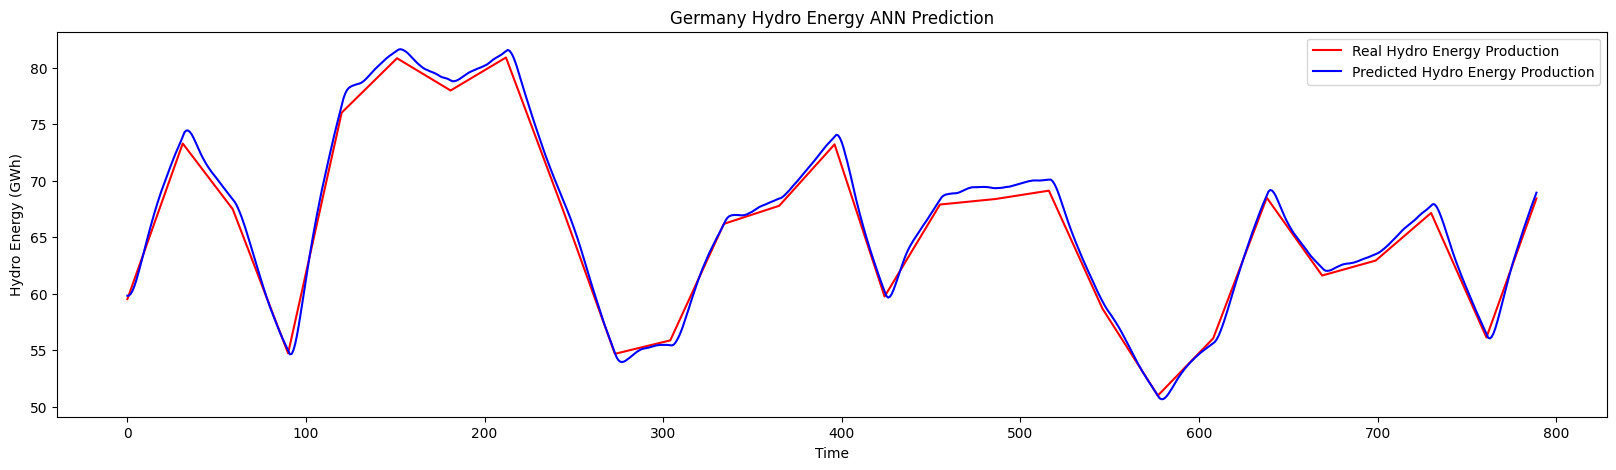

In [52]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(ann_y_pred, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('Germany Hydro Energy ANN Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [53]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.48870525]
 [0.4860964 ]
 [0.48348755]
 ...
 [0.31239538]
 [0.31286436]
 [0.31333334]]
(4019, 1)


In [18]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-365:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
print(X_train)
X_train.shape

[[0.48870525 0.4860964  0.48348755 ... 0.6162796  0.61554125 0.6148029 ]
 [0.4860964  0.48348755 0.4808787  ... 0.61554125 0.6148029  0.61406455]
 [0.48348755 0.4808787  0.47826984 ... 0.6148029  0.61406455 0.60497296]
 ...
 [0.3305504  0.32641584 0.34105989 ... 0.31098845 0.31145743 0.31192641]
 [0.32641584 0.34105989 0.35570394 ... 0.31145743 0.31192641 0.31239538]
 [0.34105989 0.35570394 0.37034799 ... 0.31192641 0.31239538 0.31286436]]


(3654, 365)

In [20]:
print(y_train)
y_train.shape

[0.61406455 0.60497296 0.59588136 ... 0.31239538 0.31286436 0.31333334]


(3654,)

In [21]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [23]:
# Initialising the RNN
ger_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
ger_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
ger_daily_uni_lstm.add(Dropout(0.2))

ger_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
ger_daily_uni_lstm.add(Dropout(0.2))

ger_daily_uni_lstm.add(LSTM(units = 64))
ger_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
ger_daily_uni_lstm.add(Dense(units = 1))

In [24]:
# Compiling the RNN
ger_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
ger_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
115/115 [==============================] - 86s 520ms/step - loss: 0.0157
Epoch 2/100
115/115 [==============================] - 64s 559ms/step - loss: 0.0048
Epoch 3/100
115/115 [==============================] - 55s 476ms/step - loss: 0.0036
Epoch 4/100
115/115 [==============================] - 62s 536ms/step - loss: 0.0031
Epoch 5/100
115/115 [==============================] - 61s 534ms/step - loss: 0.0025
Epoch 6/100
115/115 [==============================] - 67s 579ms/step - loss: 0.0022
Epoch 7/100
115/115 [==============================] - 61s 534ms/step - loss: 0.0021
Epoch 8/100
115/115 [==============================] - 69s 603ms/step - loss: 0.0022
Epoch 9/100
115/115 [==============================] - 80s 700ms/step - loss: 0.0020
Epoch 10/100
115/115 [==============================] - 79s 688ms/step - loss: 0.0019
Epoch 11/100
115/115 [==============================] - 78s 679ms/step - loss: 0.0017
Epoch 12/100
115/115 [==============================] - 88s 767

In [25]:
test[['Value']].shape

(790, 1)

In [54]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = ger_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 11s 299ms/step


In [55]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test.values))
mse = mean_squared_error(uni_lstm_y_pred, test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  0.12335613410428534
Mean Squared Error:  0.047844472661435725
Root Mean Squared Error:  0.218733794054407


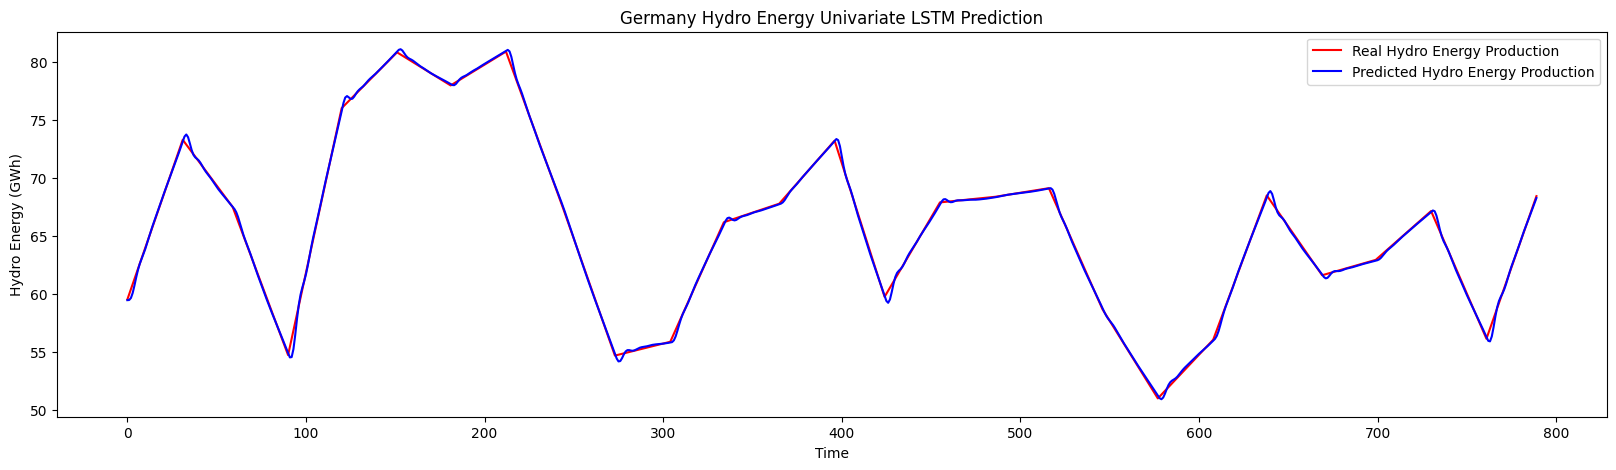

In [56]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('Germany Hydro Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [29]:
data = hydro_production_data['Germany']

data.shape

(4808, 2)

In [57]:
X = data[['Precipitation', 'Value']]
y = data[['Value']]

X.head()

,Precipitation,Value
Date,,
2010-01-01,0.074334,67.049355
2010-01-02,0.074848,66.937218
2010-01-03,0.075361,66.825081
2010-01-04,0.075874,66.712944
2010-01-05,0.076388,66.600807


In [58]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [59]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [33]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(4019, 2)
(790, 2)

(4019, 1)
(790, 1)


In [34]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

print(X_train1.shape)

(3654, 365, 2)


In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

ger_daily_multi_lstm = Sequential()
ger_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
ger_daily_multi_lstm.add(Dropout(0.2))
ger_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
ger_daily_multi_lstm.add(Dropout(0.2))
ger_daily_multi_lstm.add(LSTM(units = 64))
ger_daily_multi_lstm.add(Dropout(0.2))
ger_daily_multi_lstm.add(Dense(1))

In [36]:
ger_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

ger_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 235s 992ms/step - loss: 0.0241
Epoch 2/100
115/115 [==============================] - 107s 932ms/step - loss: 0.0044
Epoch 3/100
115/115 [==============================] - 97s 847ms/step - loss: 0.0037
Epoch 4/100
115/115 [==============================] - 93s 811ms/step - loss: 0.0030
Epoch 5/100
115/115 [==============================] - 93s 811ms/step - loss: 0.0025
Epoch 6/100
115/115 [==============================] - 94s 824ms/step - loss: 0.0024
Epoch 7/100
115/115 [==============================] - 88s 768ms/step - loss: 0.0024
Epoch 8/100
115/115 [==============================] - 76s 662ms/step - loss: 0.0021
Epoch 9/100
115/115 [==============================] - 79s 689ms/step - loss: 0.0020
Epoch 10/100
115/115 [==============================] - 74s 646ms/step - loss: 0.0022
Epoch 11/100
115/115 [==============================] - 77s 667ms/step - loss: 0.0019
Epoch 12/100
115/115 [==============================] - 75s 6

In [60]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)

X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))

multi_lstm_y_pred = ger_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)

25/25 [==============================] - 8s 249ms/step


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  0.337077800390064
Mean Squared Error:  0.18245567799916895
Root Mean Squared Error:  0.4271483091376682


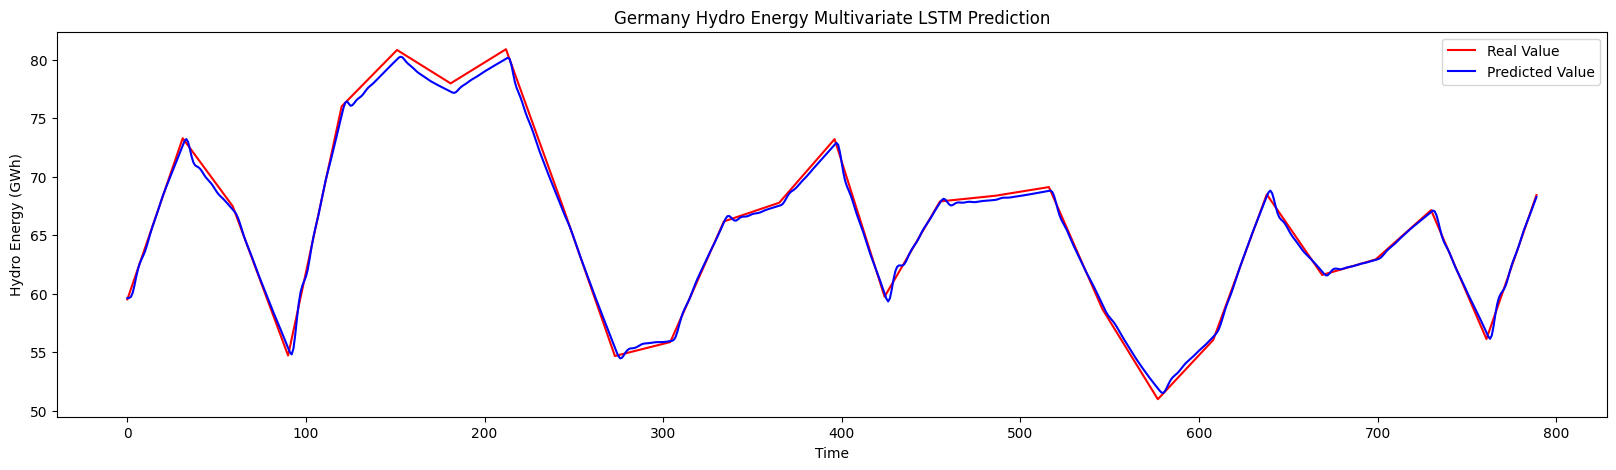

In [62]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('Germany Hydro Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Overview

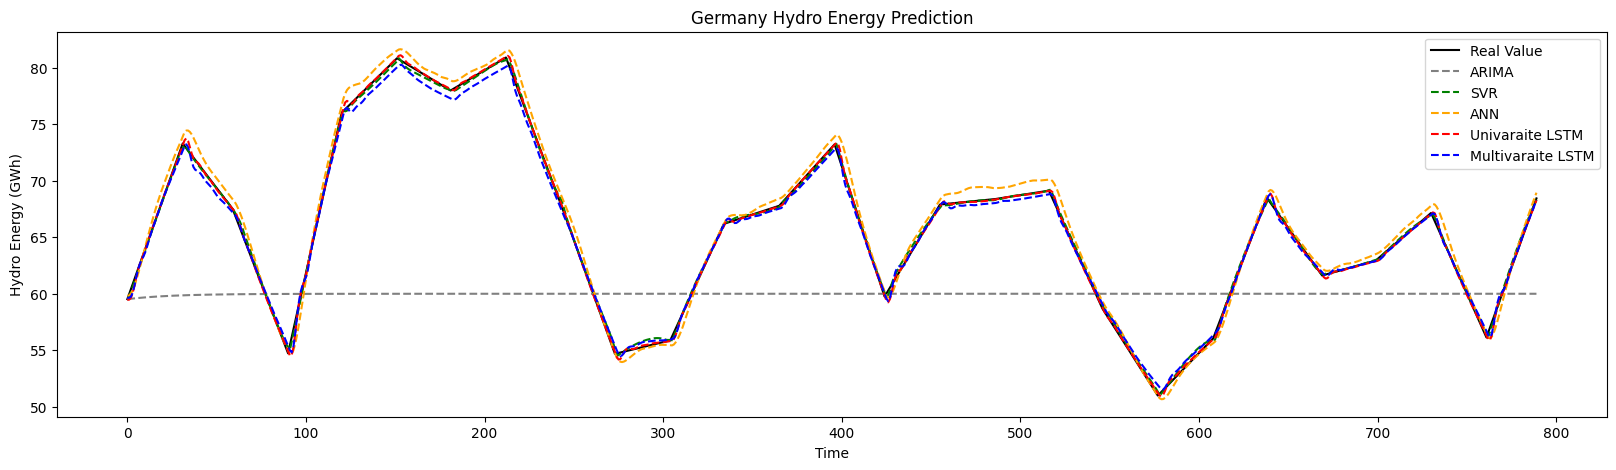

In [75]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(ann_y_pred, color='orange', linestyle='--', label='ANN')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('Germany Hydro Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [40]:
ger_daily_uni_lstm.save('ger_hydro_best_uni_lstm.h5')

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
